In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Reading in files

In [14]:
# Confirmed cases and Death rates
Original_Confirmed = pd.read_csv("/content/gdrive/MyDrive/College/CS/CS506/COVID_Insurance_Relation/Data/time_series_covid19_confirmed_US.csv")
# (3340, 435)
Original_Deaths = pd.read_csv("/content/gdrive/MyDrive/College/CS/CS506/COVID_Insurance_Relation/Data/time_series_covid19_deaths_US.csv")
# (3340, 436)

# Insurance
US_Insurance = pd.read_csv("/content/gdrive/MyDrive/College/CS/CS506/COVID_Insurance_Relation/Data/SAHIE_21MAR21_16_03_44_68.csv")
 
# Feature extraction
US_Confirmed = Original_Confirmed.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'Country_Region', 'Combined_Key'])
US_Deaths = Original_Deaths.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'Country_Region', 'Combined_Key', ]) 
US_Insurance = US_Insurance.drop(columns=['Age Category', 'Income Category', 'Race Category', 'Sex Category', 'Year', 'Demographic Group: MOE', 'Uninsured: %', 'Uninsured: %MOE', 'Insured: %MOE'])

print(US_Confirmed.columns)
print(US_Deaths.columns)
print(US_Insurance.columns)


Index(['Admin2', 'Province_State', 'Lat', 'Long_', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '3/11/21', '3/12/21', '3/13/21', '3/14/21', '3/15/21', '3/16/21',
       '3/17/21', '3/18/21', '3/19/21', '3/20/21'],
      dtype='object', length=428)
Index(['Admin2', 'Province_State', 'Lat', 'Long_', 'Population', '1/22/20',
       '1/23/20', '1/24/20', '1/25/20', '1/26/20',
       ...
       '3/11/21', '3/12/21', '3/13/21', '3/14/21', '3/15/21', '3/16/21',
       '3/17/21', '3/18/21', '3/19/21', '3/20/21'],
      dtype='object', length=429)
Index(['Name', 'Demographic Group: Number', 'Uninsured: Number',
       'Uninsured: MOE', 'Insured: Number', 'Insured: MOE', 'Insured: %'],
      dtype='object')


##Cleaning Case/Death DataFrames

In [15]:
# drop NaN values
US_Confirmed.dropna()
US_Deaths.dropna()

# drop places w no latitude/not on map
US_Confirmed = US_Confirmed.loc[(US_Confirmed['Lat'] != 0)]
US_Deaths = US_Deaths.loc[(US_Deaths['Lat'] != 0)]


stateNames = ["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", "District of Columbia", "Florida", "Georgia", "Hawaii", 
              "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", 
              "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", 
              "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", 
              "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"] 

# removing unassigned data
drop_data = ["Unassigned", "Out of", "Dukes and Nantucket", "Kansas City", "Bear River", "Kalawao", "Central Utah", "Southeast Utah", "Southwest Utah", "TriCounty", "Weber-Morgan"] # drop all these "counties"
drop_states = ["American Samoa", "Guam", "Northern Mariana Islands", "Puerto Rico", "Virgin Islands", "Diamond Princess"]

drop_i = []
for i, row in US_Confirmed.iterrows():
  # drop Provinces
  if row['Province_State'] in drop_states:
    drop_i.append(i)
  # drop unassigned/out of state data
  else:
    for d in drop_data:
      if d in str(row['Admin2']):
        drop_i.append(i)

# drop these row indices from dataFrames
US_Confirmed.drop(drop_i, inplace = True)
US_Deaths.drop(drop_i, inplace = True)

# Sum county data for state stats
State_Confirmed = []
State_Death = []
Covid_Counties = [] # temp

for i in stateNames:
  State_Confirmed.append(US_Confirmed.loc[US_Confirmed['Province_State'] == i, '3/20/21'].sum())
  State_Death.append(US_Deaths.loc[US_Deaths['Province_State'] == i, '3/20/21'].sum())
  Covid_Counties.append(US_Confirmed.loc[US_Confirmed['Province_State'] == i, 'Admin2']) # temp

Cumulative Covid Cases/Deaths?


In [ ]:
#US_Confirmed['Cumulative Cases'] = US_Confirmed[['a','b','d']].sum(axis=1)

##Cleaning Insurance DataFrame

In [16]:
# seperating state data from dataset
states_i = []
drop_i = 0
for i, row in US_Insurance.iterrows():
  if row['Name'] in stateNames:
    # DC duplicated, keep one as a county and one as a state
    if row['Name'] != "District of Columbia" or (i != states_i[-1] + 1):
      states_i.append(i)
  elif row['Name'] == "Kalawao County, HI":
    drop_i = i

State_Insurance = US_Insurance.iloc[states_i]


 # drop these row indexes from dataFrame 
US_Insurance.drop(states_i + [drop_i], inplace = True)

# removing commas/making values ints
State_Insurance['Insured: Number'] = State_Insurance['Insured: Number'].str.split(',').str.join('').astype(int)
State_Insurance['Demographic Group: Number'] = State_Insurance['Demographic Group: Number'].str.split(',').str.join('').astype(int)
US_Insurance['Insured: Number'] = US_Insurance['Insured: Number'].str.split(',').str.join('').astype(int)
US_Insurance['Demographic Group: Number'] = US_Insurance['Demographic Group: Number'].str.split(',').str.join('').astype(int)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#Models/plots

In [8]:
from sklearn.linear_model import LogisticRegression
# Initializing
#linear = LinearRegression(), #p-value?
logistic = LogisticRegression()


## States Scatter Plots

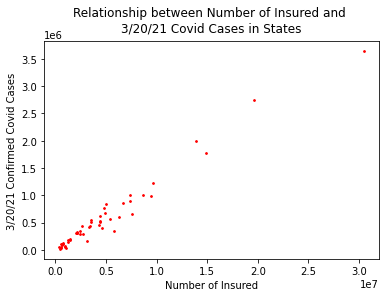

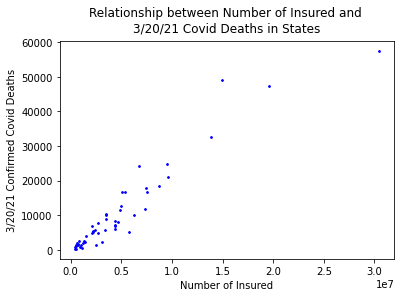

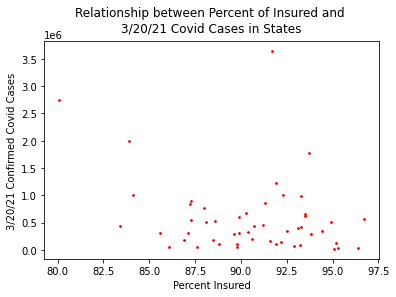

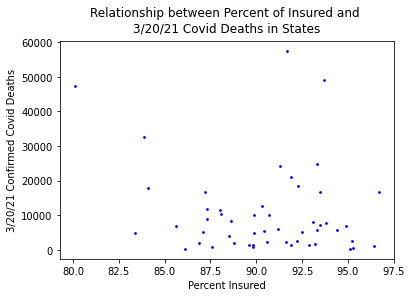

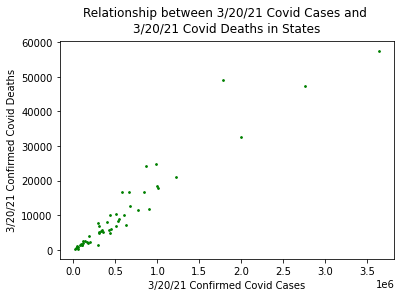

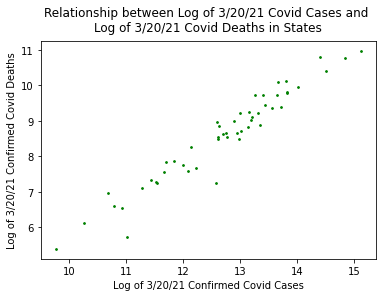

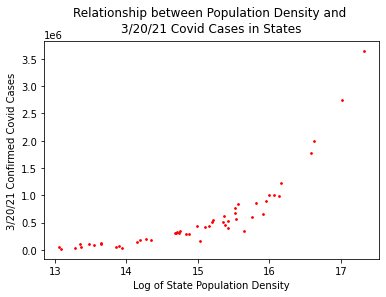

In [17]:
# x-axis: # insured, y-axis: confirmed cases
plt.scatter(State_Insurance['Insured: Number'], State_Confirmed, s = 3, c = 'r')
plt.xlabel('Number of Insured')
plt.ylabel('3/20/21 Confirmed Covid Cases')
plt.title("Relationship between Number of Insured and \n3/20/21 Covid Cases in States", fontsize = 12, pad = 10)
plt.show()

# x-axis: # insured, y-axis: deaths
plt.scatter(State_Insurance['Insured: Number'], State_Death, s = 3, c = 'b')
plt.xlabel('Number of Insured')
plt.ylabel('3/20/21 Confirmed Covid Deaths')
plt.title("Relationship between Number of Insured and \n3/20/21 Covid Deaths in States", fontsize = 12, pad = 10)
plt.show()

# x-axis: % insured, y-axis: confirmed cases
plt.scatter(State_Insurance['Insured: %'], State_Confirmed, s = 3, c = 'r')
plt.xlabel('Percent Insured')
plt.ylabel('3/20/21 Confirmed Covid Cases')
plt.title("Relationship between Percent of Insured and \n3/20/21 Covid Cases in States", fontsize = 12, pad = 10)
plt.show()

# x-axis: % insured, y-axis: deaths
plt.scatter(State_Insurance['Insured: %'], State_Death, s = 3, c = 'b')
plt.xlabel('Percent Insured')
plt.ylabel('3/20/21 Confirmed Covid Deaths')
plt.title("Relationship between Percent of Insured and \n3/20/21 Covid Deaths in States", fontsize = 12, pad = 10)
plt.show()

# x-axis: confirmed cases, y-axis: deaths
plt.scatter(State_Confirmed, State_Death, s = 3, c = 'g')
plt.xlabel('3/20/21 Confirmed Covid Cases')
plt.ylabel('3/20/21 Confirmed Covid Deaths')
plt.title("Relationship between 3/20/21 Covid Cases and \n3/20/21 Covid Deaths in States", fontsize = 12, pad = 10)
plt.show()

# x-axis: confirmed cases, y-axis: deaths
plt.scatter(np.log(State_Confirmed), np.log(State_Death), s = 3, c = 'g')
plt.xlabel('Log of 3/20/21 Confirmed Covid Cases')
plt.ylabel('Log of 3/20/21 Confirmed Covid Deaths')
plt.title("Relationship between Log of 3/20/21 Covid Cases and \nLog of 3/20/21 Covid Deaths in States", fontsize = 12, pad = 10)
plt.show()
 
# x-axis: # Population density, y-axis: confirmed cases
plt.scatter(np.log(State_Insurance['Demographic Group: Number']), State_Confirmed, s = 3, c = 'r')
plt.xlabel('Log of State Population Density')
plt.ylabel('3/20/21 Confirmed Covid Cases')
plt.title("Relationship between Population Density and \n3/20/21 Covid Cases in States", fontsize = 12, pad = 10)
plt.show()

Attempting Logistic regression

In [10]:
# x-axis: # insured, y-axis: confirmed cases
logistic.fit(US_Insurance['Insured: Number'], US_Confirmed['3/20/21']) # based on insurance and confirmed case, assume population density??
# Retrieve the model parameters.
b_log = logistic.intercept_[0]
w1_log, w2_log = logistic.coef_.T

# Calculate the intercept of the decision boundary.
c_log = -b_log/w2_log
m_log = -w1_log/w2_log

# Plot the data and the classification with the decision boundary.
x_log = np.array([US_Insurance['Insured: Number'].min(), US_Insurance['Insured: Number'].max()])
y_log = m_log*x_log + c_log

plt.plot(x_lin, y_lin, 'm')


ValueError: ignored

## Counties Scatter Plots

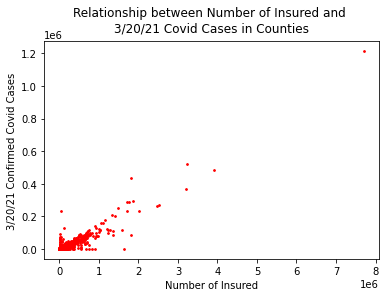

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


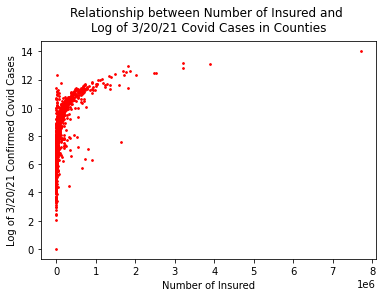

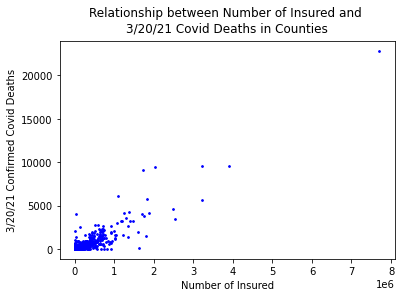

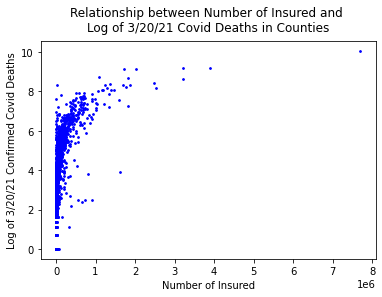

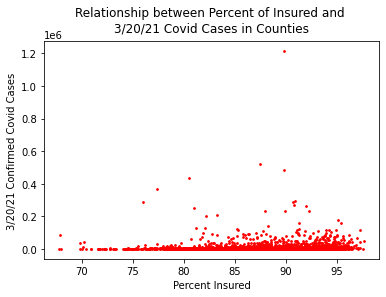

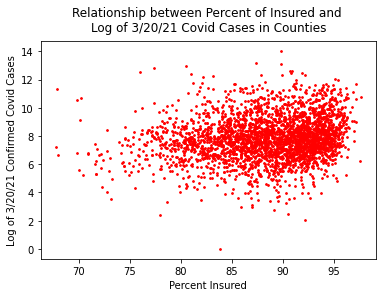

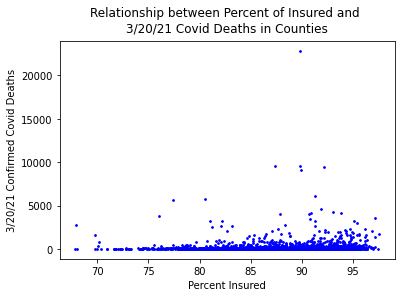

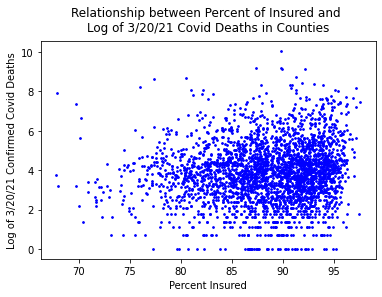

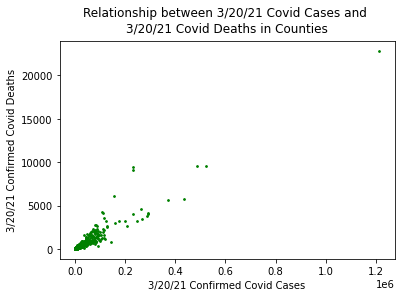

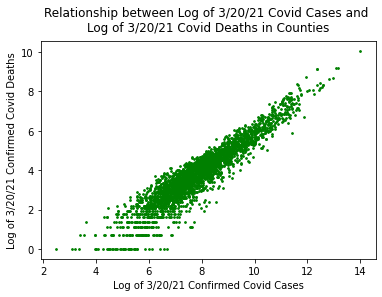

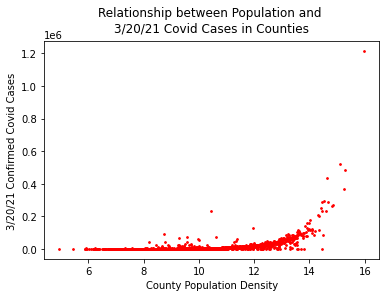

In [18]:
plt.scatter(US_Insurance['Insured: Number'], US_Confirmed['3/20/21'], s = 3, c = 'r')
plt.xlabel('Number of Insured')
plt.ylabel('3/20/21 Confirmed Covid Cases')
plt.title("Relationship between Number of Insured and \n3/20/21 Covid Cases in Counties", fontsize = 12, pad = 10)
plt.show()

# x-axis: # insured, y-axis: log of confirmed cases
plt.scatter(US_Insurance['Insured: Number'], np.log(US_Confirmed['3/20/21']), s = 3, c = 'r')
plt.xlabel('Number of Insured')
plt.ylabel('Log of 3/20/21 Confirmed Covid Cases')
plt.title("Relationship between Number of Insured and \nLog of 3/20/21 Covid Cases in Counties", fontsize = 12, pad = 10)
plt.show()

# x-axis: # insured, y-axis: confirmed deaths
plt.scatter(US_Insurance['Insured: Number'], US_Deaths['3/20/21'], s = 3, c = 'b')
plt.xlabel('Number of Insured')
plt.ylabel('3/20/21 Confirmed Covid Deaths')
plt.title("Relationship between Number of Insured and \n3/20/21 Covid Deaths in Counties", fontsize = 12, pad = 10)
plt.show()

# x-axis: # insured, y-axis: log of confirmed cases
plt.scatter(US_Insurance['Insured: Number'], np.log(US_Deaths['3/20/21']), s = 3, c = 'b')
plt.xlabel('Number of Insured')
plt.ylabel('Log of 3/20/21 Confirmed Covid Deaths')
plt.title("Relationship between Number of Insured and \nLog of 3/20/21 Covid Deaths in Counties", fontsize = 12, pad = 10)
plt.show()


# x-axis: % insured, y-axis: confirmed cases
plt.scatter(US_Insurance['Insured: %'], US_Confirmed['3/20/21'], s = 3, c = 'r')
plt.xlabel('Percent Insured')
plt.ylabel('3/20/21 Confirmed Covid Cases')
plt.title("Relationship between Percent of Insured and \n3/20/21 Covid Cases in Counties", fontsize = 12, pad = 10)
plt.show()

# x-axis: % insured, y-axis: log of confirmed cases
plt.scatter(US_Insurance['Insured: %'], np.log(US_Confirmed['3/20/21']), s = 3, c = 'r')
plt.xlabel('Percent Insured')
plt.ylabel('Log of 3/20/21 Confirmed Covid Cases')
plt.title("Relationship between Percent of Insured and \nLog of 3/20/21 Covid Cases in Counties", fontsize = 12, pad = 10)
plt.show()


# x-axis: % insured, y-axis: deaths
plt.scatter(US_Insurance['Insured: %'], US_Deaths['3/20/21'], s = 3, c = 'b')
plt.xlabel('Percent Insured')
plt.ylabel('3/20/21 Confirmed Covid Deaths')
plt.title("Relationship between Percent of Insured and \n3/20/21 Covid Deaths in Counties", fontsize = 12, pad = 10)
plt.show()

# x-axis: % insured, y-axis: log of deaths
plt.scatter(US_Insurance['Insured: %'], np.log(US_Deaths['3/20/21']), s = 3, c = 'b')
plt.xlabel('Percent Insured')
plt.ylabel('Log of 3/20/21 Confirmed Covid Deaths')
plt.title("Relationship between Percent of Insured and \nLog of 3/20/21 Covid Deaths in Counties", fontsize = 12, pad = 10)
plt.show()


# x-axis: confirmed cases, y-axis: deaths
plt.scatter(US_Confirmed['3/20/21'], US_Deaths['3/20/21'], s = 3, c = 'g')
plt.xlabel('3/20/21 Confirmed Covid Cases')
plt.ylabel('3/20/21 Confirmed Covid Deaths')
plt.title("Relationship between 3/20/21 Covid Cases and \n3/20/21 Covid Deaths in Counties", fontsize = 12, pad = 10)
plt.show()

# x-axis: log of confirmed cases, y-axis: log of deaths
plt.scatter(np.log(US_Confirmed['3/20/21']), np.log(US_Deaths['3/20/21']), s = 3, c ='g')
plt.xlabel('Log of 3/20/21 Confirmed Covid Cases')
plt.ylabel('Log of 3/20/21 Confirmed Covid Deaths')
plt.title("Relationship between Log of 3/20/21 Covid Cases and \nLog of 3/20/21 Covid Deaths in Counties", fontsize = 12, pad = 10)
plt.show()


# x-axis: # Population density, y-axis: confirmed cases
plt.scatter(np.log(US_Insurance['Demographic Group: Number']), US_Confirmed['3/20/21'], s = 3, c = 'r')
plt.xlabel('County Population Density')
plt.ylabel('3/20/21 Confirmed Covid Cases')
plt.title("Relationship between Population and \n3/20/21 Covid Cases in Counties", fontsize = 12, pad = 10)
plt.show()

## Plot of US Counties Longitude and Latitude

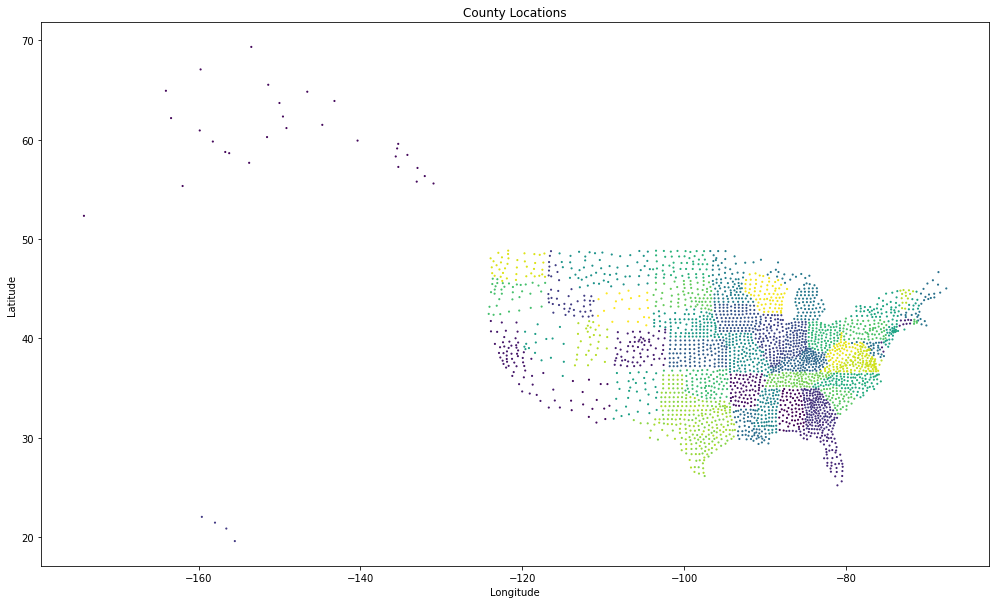

In [ ]:
# x-axis: # insured, y-axis: confirmed cases
plt.figure(figsize=(17, 10))
z = np.linspace(0.0, 1.0, len(US_Confirmed))
plt.scatter(US_Confirmed['Long_'], US_Confirmed['Lat'], s = 5, c = z, marker = ".")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("County Locations")
plt.show()

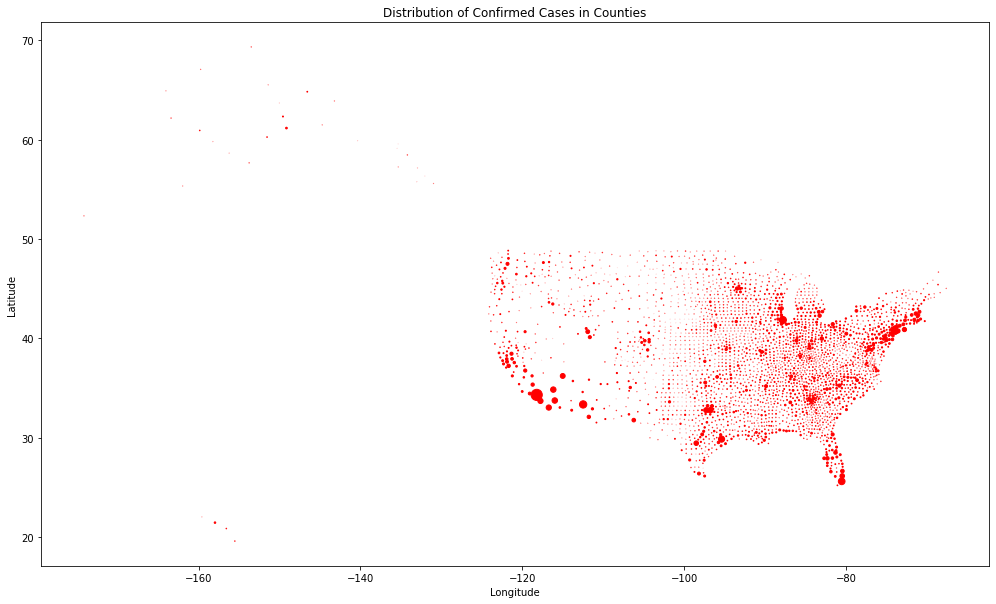

In [20]:
points_size = []

confirmed_max = US_Confirmed['3/20/21'].max()
insurance_min = US_Insurance['Insured: Number'].min()
insurance_max = US_Insurance['Insured: Number'].max()

for _, row in US_Confirmed.iterrows():
  points_size.append((row['3/20/21']/confirmed_max)*500)

points_color = []
for _, row in US_Insurance.iterrows():
  points_color.append((row['Insured: Number'] - insurance_min)/(insurance_max - insurance_min))

# x-axis: # insured, y-axis: confirmed cases
plt.figure(figsize=(17, 10))
plt.scatter(US_Confirmed['Long_'], US_Confirmed['Lat'], s = points_size, c = "r", marker = ".")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Distribution of Confirmed Cases in Counties")
plt.show()

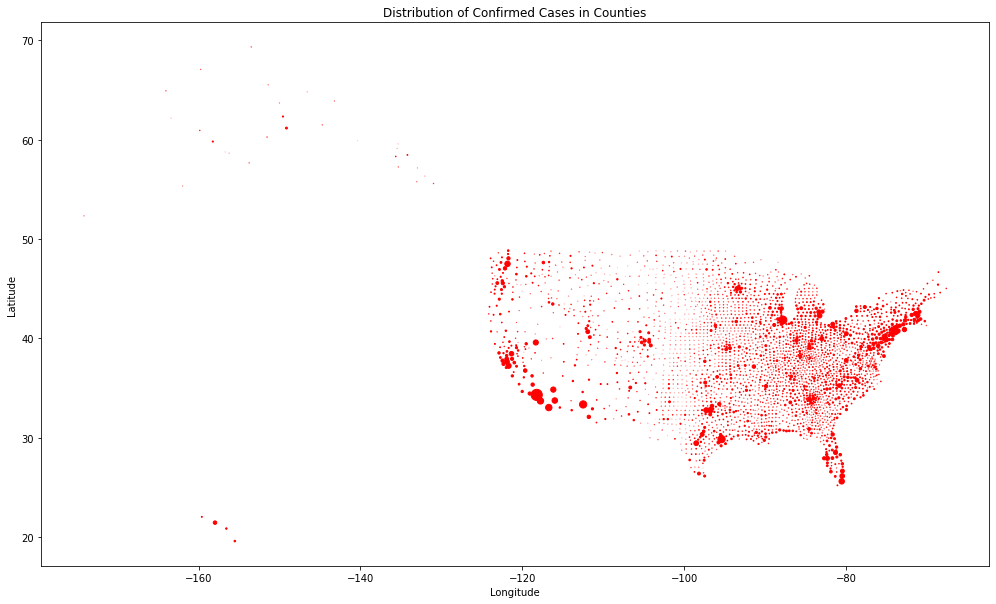

In [ ]:
points_size = []

insurance_min = US_Insurance['Insured: Number'].min()
insurance_max = US_Insurance['Insured: Number'].max()

for _, row in US_Insurance.iterrows():
  points_size.append((row['Insured: Number']/insurance_max)*500)


# x-axis: # insured, y-axis: confirmed cases
plt.figure(figsize=(17, 10))
plt.scatter(US_Confirmed['Long_'], US_Confirmed['Lat'], s = points_size, c = "r", marker = ".")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Distribution of Insurance in Counties")
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


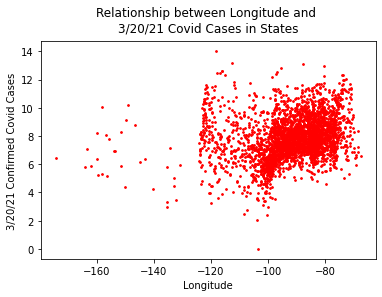

In [ ]:
# x-axis: # Longitude, y-axis: confirmed cases

plt.scatter(US_Confirmed['Long_'], np.log(US_Confirmed['3/20/21']), s=3, c = 'r')
plt.xlabel('Longitude')
plt.ylabel('3/20/21 Confirmed Covid Cases')
plt.title("Relationship between Longitude and \n3/20/21 Covid Cases in States", fontsize = 12, pad = 10)
plt.show()